# Autoencoder Approach to Feature Classification
The following is an attempt to improve the previous author's neural network classification approach by using autoencoders.  
The code from the original neural network approach can be found in the file "prepare_raw_data.py".  
It was copied into this jupyter notebook and updated to use Python 3.7 and Tensorflow 2 (which includes Keras).

Table of contents:  
[Preparing the Data and Autoencoders](#Preparing-the-Data-and-Autoencoders)  
[Undercomplete Autoencoders](#Undercomplete-Autoencoders)  
[Sparse Autoencoders](#Sparse-Autoencoders)  
[Deep Autoencoders](#Deep-Autoencoders)  
[Contractive Autoencoders](#Contractive-Autoencoders)  

In [6]:
import datareader # made by the previous author for reading the collected data
import dataextractor # same as above
import numpy as np
import tensorflow as tf
# need to disable eager execution for .get_weights() in contractive autoencoder loss to work
#tf.compat.v1.disable_eager_execution()
from tensorflow.keras.preprocessing import sequence
from tensorflow.keras.models import Sequential, Model
from tensorflow.keras.layers import Dense, Dropout, Activation, Input
from tensorflow.keras.layers import LSTM
from tensorflow.keras.layers import Conv1D, MaxPooling1D
import json

from sklearn.preprocessing import StandardScaler, MinMaxScaler

from tensorflow import keras
from tensorflow.keras import layers, regularizers
import matplotlib.pyplot as plt

tf.keras.backend.set_floatx('float32') # call this, to set keras to use float32 to avoid a warning message
metrics = ['accuracy',
           keras.metrics.TruePositives(),
           keras.metrics.FalsePositives(),
           keras.metrics.TrueNegatives(),
           keras.metrics.FalseNegatives()]

AttributeError: module 'tensorflow' has no attribute 'keras'

In [7]:
np.random.seed(4)
tf.random.set_seed(2)

AttributeError: module 'tensorflow' has no attribute 'random'

This is the original author's code, just copied into separate cells of this jupyter notebook:

In [ ]:
def get_busy_vs_relax_timeframes(path, ident, seconds):
    """Returns raw data from either 'on task' or 'relax' time frames and their class (0 or 1).
    TODO: join functions"""

    dataread = datareader.DataReader(path, ident)  # initialize path to data
    data = dataread.read_grc_data()  # read from files
    samp_rate = int(round(len(data[1]) / max(data[0])))
    cog_res = dataread.read_cognitive_load_study(str(ident) + '-primary-extract.txt')

    tasks_data = np.empty((0, seconds*samp_rate))
    tasks_y = np.empty((0, 1))

    busy_n = dataread.get_data_task_timestamps(return_indexes=True)
    relax_n = dataread.get_relax_timestamps(return_indexes=True)

    for i in cog_res['task_number']:
        task_num_table = i - 225  # 0 - 17

        ### task versus relax (1 sample each)
        dataextract = dataextractor.DataExtractor(data[0][busy_n[task_num_table][0]:busy_n[task_num_table][1]],
                                                  data[1][busy_n[task_num_table][0]:busy_n[task_num_table][1]],
                                                  samp_rate)

        dataextract_relax = dataextractor.DataExtractor(data[0][relax_n[task_num_table][0]:relax_n[task_num_table][1]],
                                                        data[1][relax_n[task_num_table][0]:relax_n[task_num_table][1]],
                                                        samp_rate)
        try:
            tasks_data = np.vstack((tasks_data, dataextract.y[-samp_rate * seconds:]))
            tasks_y = np.vstack((tasks_y, 1))
            tasks_data = np.vstack((tasks_data, dataextract_relax.y[-samp_rate * seconds:]))
            tasks_y = np.vstack((tasks_y, 0))
        except ValueError:
            continue
#             print(ident)  # ignore short windows

    return tasks_data, tasks_y


In [ ]:
def get_engagement_increase_vs_decrease_timeframes(path, ident, seconds):
    """Returns raw data from either engagement 'increase' or 'decrease' time frames and their class (0 or 1).
    TODO: join functions"""

    dataread = datareader.DataReader(path, ident)  # initialize path to data
    data = dataread.read_grc_data()  # read from files
    samp_rate = int(round(len(data[1]) / max(data[0])))
    cog_res = dataread.read_cognitive_load_study(str(ident) + '-primary-extract.txt')

    tasks_data = np.empty((0, seconds * samp_rate))
    tasks_y = np.empty((0, 1))

    busy_n = dataread.get_data_task_timestamps(return_indexes=True)
    relax_n = dataread.get_relax_timestamps(return_indexes=True)

    for i in cog_res['task_number']:
        task_num_table = i - 225  # 0 - 17

        ### engagement increase / decrease
        if task_num_table == 0:
            continue
        mid = int((relax_n[task_num_table][0] + relax_n[task_num_table][1])/2)
        length = int(samp_rate*30)
        for j in range(10):
            new_end = int(mid-j*samp_rate)

            new_start2 = int(mid+j*samp_rate)

            dataextract_decrease = dataextractor.DataExtractor(data[0][new_end - length:new_end],
                                                               data[1][new_end-length:new_end],
                                                               samp_rate)

            dataextract_increase = dataextractor.DataExtractor(data[0][new_start2: new_start2 + length],
                                                               data[1][new_start2: new_start2 + length], samp_rate)

            try:
                tasks_data = np.vstack((tasks_data, dataextract_increase.y))
                tasks_y = np.vstack((tasks_y, 1))
                tasks_data = np.vstack((tasks_data, dataextract_decrease.y))
                tasks_y = np.vstack((tasks_y, 0))
            except ValueError:
                print(ident)  # ignore short windows

    return tasks_data, tasks_y


In [ ]:
def get_task_complexities_timeframes(path, ident, seconds):
    """Returns raw data along with task complexity class.
    TODO: join functions. Add parameter to choose different task types and complexities"""

    dataread = datareader.DataReader(path, ident)  # initialize path to data
    data = dataread.read_grc_data()  # read from files
    samp_rate = int(round(len(data[1]) / max(data[0])))
    cog_res = dataread.read_cognitive_load_study(str(ident) + '-primary-extract.txt')

    tasks_data = np.empty((0, seconds*samp_rate))
    tasks_y = np.empty((0, 1))

    busy_n = dataread.get_data_task_timestamps(return_indexes=True)
    relax_n = dataread.get_relax_timestamps(return_indexes=True)

    for i in cog_res['task_number']:
        task_num_table = i - 225  # 0 - 17

        ### task complexity classification
        if cog_res['task_complexity'][task_num_table] == 'medium':
            continue
        # if cog_res['task_label'][task_num_table] == 'FA' or cog_res['task_label'][task_num_table] == 'HP':
        #     continue
        if cog_res['task_label'][task_num_table] != 'NC':
            continue
        map_compl = {
            'low': 0,
            'medium': 2,
            'high': 1
        }
        for j in range(10):
            new_end = int(busy_n[task_num_table][1] - j * samp_rate)
            new_start = int(new_end - samp_rate*30)
            dataextract = dataextractor.DataExtractor(data[0][new_start:new_end],
                                                      data[1][new_start:new_end], samp_rate)
            try:
                tasks_data = np.vstack((tasks_data, dataextract.y))
                tasks_y = np.vstack((tasks_y, map_compl.get(cog_res['task_complexity'][task_num_table])))
            except ValueError:
                print(ident)

    return tasks_data, tasks_y


In [ ]:
def get_TLX_timeframes(path, ident, seconds):
    """Returns raw data along with task load index class.
    TODO: join functions. Add parameter to choose different task types and complexities"""

    dataread = datareader.DataReader(path, ident)  # initialize path to data
    data = dataread.read_grc_data()  # read from files
    samp_rate = int(round(len(data[1]) / max(data[0])))
    cog_res = dataread.read_cognitive_load_study(str(ident) + '-primary-extract.txt')

    tasks_data = np.empty((0, seconds*samp_rate))
    tasks_y = np.empty((0, 1))

    busy_n = dataread.get_data_task_timestamps(return_indexes=True)
    relax_n = dataread.get_relax_timestamps(return_indexes=True)

    for i in cog_res['task_number']:
        task_num_table = i - 225  # 0 - 17

        ### task load index
        if cog_res['task_complexity'][task_num_table] == 'medium' or cog_res['task_label'][task_num_table] != 'PT':
            continue
        for j in range(10):
            new_end = int(busy_n[task_num_table][1] - j * samp_rate)
            new_start = int(new_end - samp_rate*30)
            dataextract = dataextractor.DataExtractor(data[0][new_start:new_end],
                                                      data[1][new_start:new_end], samp_rate)
            try:
                tasks_data = np.vstack((tasks_data, dataextract.y))
                tasks_y = np.vstack((tasks_y, cog_res['task_load_index'][task_num_table]))
            except ValueError:
                print(ident)

    return tasks_data, tasks_y


In [ ]:
def get_data_from_idents(path, idents, seconds):
    """Go through all user data and take out windows of only <seconds> long time frames,
    along with the given class (from 'divide_each_task' function).
    """
    samp_rate = 43  # hard-coded sample rate
    data, ys = np.empty((0, samp_rate*seconds)), np.empty((0, 1))
    for i in idents:
        x, y = get_busy_vs_relax_timeframes(path, i, seconds) # either 'get_busy_vs_relax_timeframes',
        # get_engagement_increase_vs_decrease_timeframes, get_task_complexities_timeframes or get_TLX_timeframes
        # TODO: ^ modify, so that different functions can be accessible by parameter
        data = np.vstack((data, x))
        ys = np.vstack((ys, y))
    return data, ys


In [ ]:
def model_build_reg():
    """Neural network model for regression problem."""

    print('Build model...')

    data_dim = 1

    # Convolution
    kernel_size = 10
    filters = 64
    strides = 4
    # pooling
    pool_size = 4

    # LSTM
    lstm_output_size = 256

    model = Sequential()
    model.add(Dropout(0.25))
    model.add(Conv1D(filters,
                     kernel_size,
                     padding='valid',
                     activation='relu',
                     strides=strides))
    model.add(MaxPooling1D(pool_size=pool_size))
    model.add(Conv1D(filters,
                     kernel_size,
                     padding='valid',
                     activation='relu',
                     strides=strides))
    model.add(MaxPooling1D(pool_size=pool_size))
    # #
    model.add(Dropout(0.25))
    model.add(LSTM(lstm_output_size))
    model.add(Dense(1))

    model.compile(loss='mean_squared_error',
                  optimizer='adam',
                  metrics=['mae'])

    return model


In [ ]:
def model_build_multi():
    """Neural network model for multi class problem."""

    print('Build model...')

    # Convolution
    kernel_size = 10
    filters = 64
    strides = 4
    # pooling
    pool_size = 4

    # LSTM
    lstm_output_size = 256

    model = Sequential()
    model.add(Dropout(0.25))
    model.add(Conv1D(filters,
                     kernel_size,
                     padding='valid',
                     activation='relu',
                     strides=strides))

    model.add(MaxPooling1D(pool_size=pool_size))
    model.add(Conv1D(filters,
                     kernel_size,
                     padding='same',
                     activation='relu',
                     strides=strides))
    model.add(MaxPooling1D(pool_size=pool_size))
    model.add(Dropout(0.25))
    model.add(LSTM(lstm_output_size))
    # model.add(Dense(1))
    model.add(Activation('softmax'))

    model.compile(loss='sparse_categorical_crossentropy',
                  optimizer='adam',
                  metrics=['accuracy'])

    return model


In [ ]:
def model_build_bin():
    """Neural network model for binary problem."""

    print('Build model...')

    # Convolution
    kernel_size = 200
    filters = 64
    strides = 4
    # pooling
    pool_size = 4
    # LSTM
    lstm_output_size = 256

    model = Sequential()
    model.add(Dropout(0.25))
    model.add(Conv1D(filters,
                     kernel_size,
                     padding='valid',
                     activation='relu',
                     strides=strides))

    model.add(MaxPooling1D(pool_size=pool_size))
    model.add(Conv1D(filters,
                     kernel_size,
                     padding='same',
                     activation='relu',
                     strides=strides))
    model.add(MaxPooling1D(pool_size=pool_size))
    # #
    model.add(Dropout(0.25))
    model.add(LSTM(lstm_output_size))
    model.add(Dense(1))
    model.add(Activation('sigmoid'))

    model.compile(loss='binary_crossentropy',
                  optimizer='adam',
                  metrics=metrics)

    return model


In [ ]:
def model_train(model, x_train, y_train, batch_size, epochs, x_valid, y_valid, x_test, y_test):
    """Train model with the given training, validation, and test set, with appropriate batch size and # epochs."""
    print('Train...')
    epoch_data = model.fit(x_train, y_train, batch_size=batch_size, epochs=epochs, validation_data=(x_valid, y_valid), verbose=0)
    print('Evaluate...')
    score = model.evaluate(x_test, y_test, batch_size=batch_size)
    acc = score[1]
    score = score[0]
    return score, acc, epoch_data


In [ ]:
def sequence_padding(x, maxlen):
    """Pad sequences (all have to be same length)."""
    print('Pad sequences (samples x time)')
    return sequence.pad_sequences(x, maxlen=maxlen, dtype=np.float)


In [ ]:
def __main__():
    path = '../../StudyData/' #'E:/signal_acquiring/'

#     idents = ['1mpau']
    idents = ['2gu87', 'iz2ps', '1mpau', '7dwjy', '7swyk', '94mnx', 'bd47a', 'c24ur', 'ctsax', 'dkhty', 'e4gay',
              'ef5rq', 'f1gjp', 'hpbxa', 'pmyfl', 'r89k1', 'tn4vl', 'td5pr', 'gyqu9', 'fzchw', 'l53hg', '3n2f9',
              '62i9y']

    # idents = ['7dwjy', 'bd47a', 'f1gjp', 'hpbxa', 'l53hg', 'tn4vl']
    # idents = ['94mnx', 'fzchw', 'ef5rq', 'iz2ps', 'c24ur', 'td5pr', '3n2f9', 'r89k1']

    user_epoch_data = {}
    seconds = 30  # time window length
    
    n = len(idents)
    # leave out person out validation
    # range 1 while testing, todo: change back to len(idents)
    for ident in range(3):#len(idents)):
        train_idents = [x for i, x in enumerate(idents) if (i != ident and i != (n-1+ident)%n)]
        validation_idents = [idents[ident]]
        test_idents = [idents[ident-1]]

        x_train, y_train = get_data_from_idents(path, train_idents, seconds)
        x_valid, y_valid = get_data_from_idents(path, validation_idents, seconds)
        x_test, y_test = get_data_from_idents(path, test_idents, seconds)

        sscaler = StandardScaler()
        sscaler.fit(np.vstack((x_train, x_test, x_valid)))
        x_train = sscaler.transform(x_train)
        x_valid = sscaler.transform(x_valid)
        x_test = sscaler.transform(x_test)

        mmscaler = MinMaxScaler()
        mmscaler.fit(np.vstack((x_train, x_test, x_valid)))
        x_train = mmscaler.transform(x_train)
        x_valid = mmscaler.transform(x_valid)
        x_test = mmscaler.transform(x_test)
        
        x_train = x_train.reshape(-1, x_train[0].shape[0], 1)
        x_valid = x_valid.reshape(-1, x_valid[0].shape[0], 1)
        x_test = x_test.reshape(-1, x_test[0].shape[0], 1)
        
        # Training
        batch_size = 256
        epochs = 100

        model = model_build_bin()
        # model = model_build_multi()
        # model = model_build_reg()
        
        sc, curr_acc, epoch_data = model_train(model, x_train, y_train, batch_size, epochs, x_valid, y_valid, x_test,
                                               y_test)

        accs_main.append(curr_acc)
        
        epoch_data.history['user_id'] = idents[ident]
        user_epoch_data[idents[ident]] = epoch_data.history

        jsonformat = json.dumps(str(user_epoch_data))
        f = open("./AEOutput/compl2_2_NC_kernel_200_pool_4_filter_64_strides_4_lstm_256.json", "w")
        f.write(jsonformat)
        f.close()

    # print some statistics
    tmp = accs_main
    print("\n\n")
    print("accuracies:")
    print("- min:", np.min(tmp))
    print("- max:", np.max(tmp))
    print("- mean:", np.mean(tmp))

In [2]:
# store accuracies to compare at the end
accs_main = []

In [ ]:
__main__()

# Preparing the Data and Autoencoders

### Prepare the Data
Read the data from files and store it into arrays.

In [3]:
# Mostly a copy of the code in __main__(), used for reading the data into an array
seconds = 30  # time window length
idents = ['2gu87', 'iz2ps', '1mpau', '7dwjy', '7swyk', '94mnx', 'bd47a', 'c24ur', 'ctsax', 'dkhty', 'e4gay',
              'ef5rq', 'f1gjp', 'hpbxa', 'pmyfl', 'r89k1', 'tn4vl', 'td5pr', 'gyqu9', 'fzchw', 'l53hg', '3n2f9',
              '62i9y']
path = '../../StudyData/'

train_idents = idents[:-2]
validation_idents = [idents[-1]]
test_idents = [idents[-2]]

x_train, y_train = get_data_from_idents(path, train_idents, seconds)
x_valid, y_valid = get_data_from_idents(path, validation_idents, seconds)
x_test, y_test = get_data_from_idents(path, test_idents, seconds)

# x_train = x_train.reshape(-1, x_train[0].shape[0], 1)
# x_valid = x_valid.reshape(-1, x_valid[0].shape[0], 1)
# x_test = x_test.reshape(-1, x_test[0].shape[0], 1)

print("x_train shape:", x_train.shape, "  x_test shape:", x_test.shape)

NameError: name 'get_data_from_idents' is not defined

### Preprocess the Data
Prepare two versions of the data:
- Normalize original data (**x_\***): reffered to as **normalized data** from now on,
- subsampled, filtered, then normalized data (**x2_\***): reffered to as **shortened data** form now on.

In [17]:
from scipy.ndimage.filters import gaussian_filter1d

step = 5 # take each step-th element of the array
sigma = 2 # sigma for gaussian filter

def convolve(x): # helper function for applying along axis
    tmp = gaussian_filter1d(x, sigma=sigma, mode="mirror")
    tmp = normalize(tmp)
    return tmp

def normalize(x): # helper function for applying along axis
    #normalize the data
    tmp = x
    tmp_min = np.min(tmp)
    tmp_max = np.max(tmp)
    top_norm = tmp-tmp_min
    bot_norm = tmp_max-tmp_min
    if (bot_norm == 0): # avoid division by 0
        bot_norm = 1
    tmp = top_norm/bot_norm
    return tmp

# Prepare another set of data that is subsampled, filtered and normalized
# Use np.apply_along_axis to apply the above function to each row of the array separately
x2_train = x_train[:,1::step]
x2_train = np.apply_along_axis(convolve, 1, x2_train)

x2_valid = x_valid[:,1::step]
x2_valid = np.apply_along_axis(convolve, 1, x2_valid)

x2_test = x_test[:,1::step]
x2_test = np.apply_along_axis(convolve, 1, x2_test)

sscaler = StandardScaler()
sscaler.fit(np.vstack((x2_train, x2_test, x2_valid)))
x2_train = sscaler.transform(x2_train)
x2_valid = sscaler.transform(x2_valid)
x2_test = sscaler.transform(x2_test)

mmscaler = MinMaxScaler()
mmscaler.fit(np.vstack((x2_train, x2_test, x2_valid)))
x2_train = mmscaler.transform(x2_train)
x2_valid = mmscaler.transform(x2_valid)
x2_test = mmscaler.transform(x2_test)

# Normalize original (normalized) data
# Use np.apply_along_axis to apply the above function to each row of the array separately
# x_train = np.apply_along_axis(normalize, 1, x_train)
# x_valid = np.apply_along_axis(normalize, 1, x_valid)
# x_test = np.apply_along_axis(normalize, 1, x_test)

sscaler = StandardScaler()
sscaler.fit(np.vstack((x_train, x_test, x_valid)))
x_train = sscaler.transform(x_train)
x_valid = sscaler.transform(x_valid)
x_test = sscaler.transform(x_test)

mmscaler = MinMaxScaler()
mmscaler.fit(np.vstack((x_train, x_test, x_valid)))
x_train = mmscaler.transform(x_train)
x_valid = mmscaler.transform(x_valid)
x_test = mmscaler.transform(x_test)

print("Normalized data:", x_test.shape, "  Shortened data:", x2_test.shape)

Normalized data: (33, 1290)   Shortened data: (33, 258)


<Figure size 432x288 with 0 Axes>

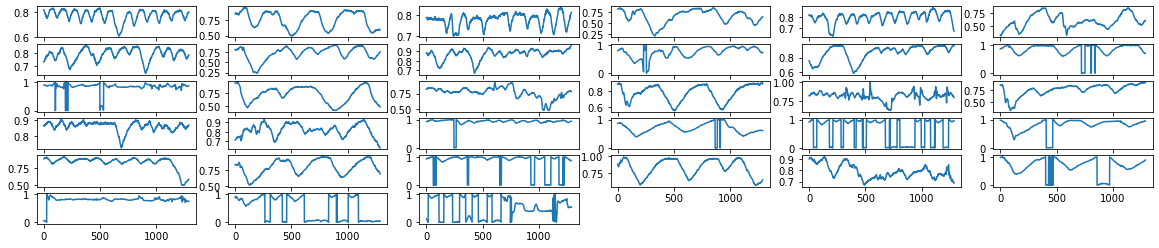

<Figure size 432x288 with 0 Axes>

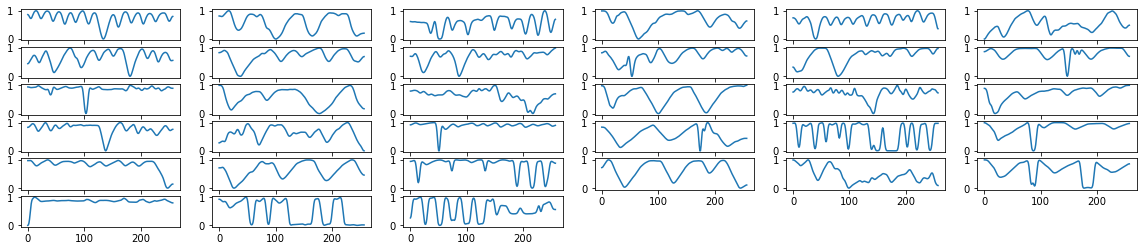

In [18]:
#plot n samples to compare the normalized data to the shortened data
n = 33

#plot some normalized data values
plt.figure()
plt.figure(figsize=(20, 4))
for i in range(n):
    plt.subplot(n/5, 6, i+1)
    plt.plot(x_train[i])

#plot some shortened data values
plt.figure()
plt.figure(figsize=(20, 4))
for i in range(n):
    plt.subplot(n/5, 6, i+1)
    plt.plot(x2_train[i])

### Prepare a Classifier  
Prepare a function that builds a new model, that will get attached to the encoded part of the autoencoder.  
**Work in progress**

In [19]:
def classifier(model, kernel_size = 16, filters = 16, strides = 1, pool_size = 2, lstm_output_size = 32):
    # Todo: make a better model

    model = layers.Reshape((-1, 1), input_shape=(model.shape)) (model)

    model = Conv1D(filters,
                 kernel_size,
                 padding='valid',
                 activation='relu',
                 strides=strides) (model)
    
    model = MaxPooling1D(pool_size=pool_size) (model)
    
    model = Conv1D(filters,
                     kernel_size,
                     padding='same',
                     activation='relu',
                     strides=strides) (model)
    
    model = MaxPooling1D(pool_size=pool_size) (model)

    model = LSTM(lstm_output_size, activation='sigmoid') (model)

    model = Dense(1, activation='sigmoid') (model)
    return model

### Undercomplete Autoencoders
from https://blog.keras.io/building-autoencoders-in-keras.html

In [20]:
def undercomplete_ae(x, encoding_dim=64):
    # Simplest possible autoencoder from https://blog.keras.io/building-autoencoders-in-keras.html

    # this is our input placeholder
    input_data = Input(shape=x[0].shape, name="input")
    dropout = Dropout(0.25, name="dropout")(input_data)
    # "encoded" is the encoded representation of the input
    encoded = Dense(encoding_dim, activation='relu', name="encoded")(dropout)
    
    # "decoded" is the lossy reconstruction of the input
    decoded = Dense(x[0].shape[0], activation='sigmoid', name="decoded")(encoded)

    autoencoder =  Model(input_data, decoded)
    
    # compile the model
    autoencoder.compile(optimizer='adam', loss='binary_crossentropy', metrics=metrics)
    
    return autoencoder, encoded

#### Undercomplete Autoencoder - Normalized Input Data

Build the autoencoder:

In [21]:
autoencoder, _ = undercomplete_ae(x_train, 60)
print(x_train.shape)

(689, 1290)


Print the summary of the autoencoder:

Model: "model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input (InputLayer)           [(None, 1290)]            0         
_________________________________________________________________
dropout (Dropout)            (None, 1290)              0         
_________________________________________________________________
encoded (Dense)              (None, 60)                77460     
_________________________________________________________________
decoded (Dense)              (None, 1290)              78690     
Total params: 156,150
Trainable params: 156,150
Non-trainable params: 0
_________________________________________________________________


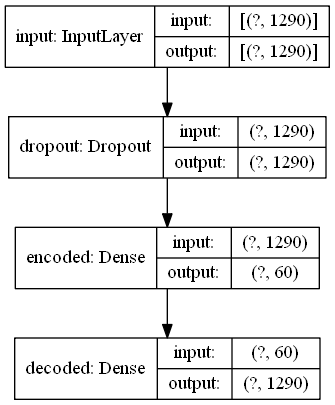

In [22]:
autoencoder.summary()
keras.utils.plot_model(autoencoder, "./AEOutput/undercomplete_ae.png", show_shapes=True)

Train the model:

In [23]:
# Training
batch_size = 256
epochs = 200

# Fit the model
autoencoder.fit(x_train, x_train,
                epochs=epochs,
                batch_size=batch_size,
                shuffle=True,
                verbose=0,
                validation_data=(x_test, x_test))
print("Finished Training!", "\nbatch size:", batch_size, "\nepochs:", epochs)

Finished Training! 
batch size: 256 
epochs: 200


Plot some input data and the corresponding reconstructed data: 

<Figure size 432x288 with 0 Axes>

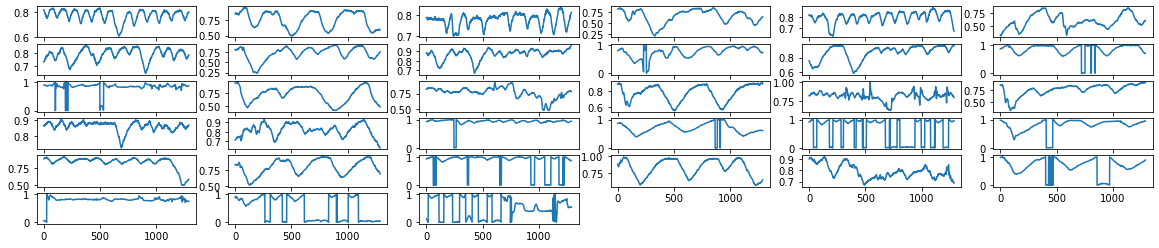

<Figure size 432x288 with 0 Axes>

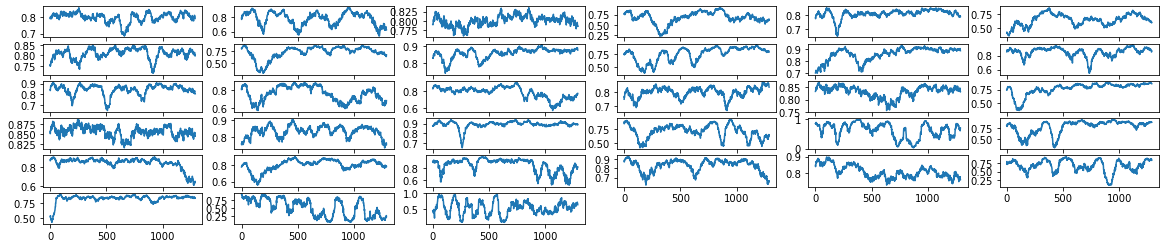

In [24]:
x_pred = autoencoder.predict(x_train)


#plot n samples to compare the input and reconstruction
n = 33

#plot the input values
plt.figure()
plt.figure(figsize=(20, 4))
for i in range(n):
    plt.subplot(n/5, 6, i+1)
    plt.plot(x_train[i])
    
#plot the reconstructed values
plt.figure()
plt.figure(figsize=(20, 4))
for i in range(n):
    plt.subplot(n/5, 6, i+1)
    plt.plot(x_pred[i])

Combine the encoder layer and the classification model:

In [25]:
# leave out person out validation
user_epoch_data = {}
seconds = 30  # time window length
accs_undercomplete = []

n = len(idents)
for ident in range(3):
    train_idents = [x for i, x in enumerate(idents) if (i != ident and i != (n-1+ident)%n)]
    validation_idents = [idents[ident]]
    test_idents = [idents[ident-1]]

    xt_train, yt_train = get_data_from_idents(path, train_idents, seconds)
    xt_valid, yt_valid = get_data_from_idents(path, validation_idents, seconds)
    xt_test, yt_test = get_data_from_idents(path, test_idents, seconds)

#     xt_train = np.apply_along_axis(normalize, 1, xt_train)
#     xt_valid = np.apply_along_axis(normalize, 1, xt_valid)
#     xt_test = np.apply_along_axis(normalize, 1, xt_test)
    sscaler = StandardScaler()
    sscaler.fit(np.vstack((xt_train, xt_test, xt_valid)))
    xt_train = sscaler.transform(xt_train)
    xt_valid = sscaler.transform(xt_valid)
    xt_test = sscaler.transform(xt_test)

    mmscaler = MinMaxScaler()
    mmscaler.fit(np.vstack((xt_train, xt_test, xt_valid)))
    xt_train = mmscaler.transform(xt_train)
    xt_valid = mmscaler.transform(xt_valid)
    xt_test = mmscaler.transform(xt_test)

    # AE Training
    batch_size = 256
    epochs = 200

    autoencoder, encoded = undercomplete_ae(x_train, 60)
    
    print("\n\nAUTOENCODER TRAINING: ", ident)
    sc, curr_acc, epoch_data = model_train(autoencoder, xt_train, xt_train, batch_size, epochs,
                                           xt_valid, xt_valid, xt_test, xt_test)
    
    model = classifier(encoded, kernel_size = 16, filters = 16, strides = 1, pool_size = 2, lstm_output_size = 16)

    model = Model(inputs=autoencoder.inputs, outputs=model)
    model.compile(loss='binary_crossentropy',
                  optimizer='adam',
                  metrics=metrics)

    # Classifier Training
    batch_size = 256
    epochs = 100
    
    print("\n\nCLASSIFICATION TRAINING: ", ident)
    sc, curr_acc, epoch_data = model_train(model, xt_train, yt_train, batch_size, epochs,
                                           xt_valid, yt_valid, xt_test, yt_test)

    accs_undercomplete.append(curr_acc)
    
    # This code remains from the previous author, copied from __main__()
    epoch_data.history['user_id'] = idents[ident]
    user_epoch_data[idents[ident]] = epoch_data.history

    jsonformat = json.dumps(str(user_epoch_data))
    f = open("./AEOutput/compl2_2_NC_kernel_200_pool_4_filter_64_strides_4_lstm_256.json", "w")
    f.write(jsonformat)
    f.close()
    
# print some statistics
tmp = accs_undercomplete
print("\n\n")
print("accuracies:")
print("- min:", np.min(tmp))
print("- max:", np.max(tmp))
print("- mean:", np.mean(tmp))



AUTOENCODER TRAINING:  0
Train...
Evaluate...
28/28 [==============================] - 0s 36us/sample - loss: 0.5208 - accuracy: 2.4917e-04 - true_positives: 455.0000 - false_positives: 2.0000 - true_negatives: 6.0000 - false_negatives: 35657.0000


CLASSIFICATION TRAINING:  0
Train...
Evaluate...
28/28 [==============================] - 0s 71us/sample - loss: 0.6254 - accuracy: 0.7143 - true_positives: 15.0000 - false_positives: 7.0000 - true_negatives: 5.0000 - false_negatives: 1.0000


AUTOENCODER TRAINING:  1
Train...
Evaluate...
34/34 [==============================] - 0s 29us/sample - loss: 0.4827 - accuracy: 0.0032 - true_positives: 39638.0000 - false_positives: 55.0000 - true_negatives: 69.0000 - false_negatives: 4098.0000


CLASSIFICATION TRAINING:  1
Train...
Evaluate...
34/34 [==============================] - 0s 59us/sample - loss: 0.5904 - accuracy: 0.6765 - true_positives: 14.0000 - false_positives: 8.0000 - true_negatives: 9.0000 - false_negatives: 3.0000


AUTOENCODER

#### Undercomplete Autoencoder - Shortened Input Data

Build the autoencoder:

In [26]:
autoencoder2, _ = undercomplete_ae(x2_train, 24)

Print the summary of the autoencoder:

Model: "model_7"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input (InputLayer)           [(None, 258)]             0         
_________________________________________________________________
dropout (Dropout)            (None, 258)               0         
_________________________________________________________________
encoded (Dense)              (None, 24)                6216      
_________________________________________________________________
decoded (Dense)              (None, 258)               6450      
Total params: 12,666
Trainable params: 12,666
Non-trainable params: 0
_________________________________________________________________


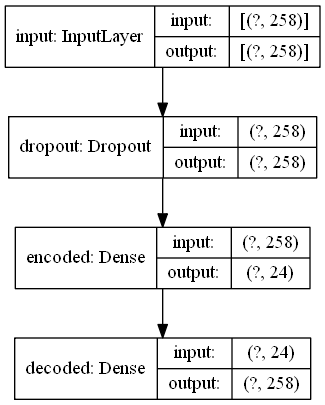

In [27]:
autoencoder2.summary()
keras.utils.plot_model(autoencoder2, "./AEOutput/undercomplete_ae2.png", show_shapes=True)

Train the model:

In [28]:
# Training
batch_size = 256
epochs = 200

# Fit the model
autoencoder2.fit(x2_train, x2_train,
                epochs=epochs,
                batch_size=batch_size,
                shuffle=True,
                verbose=0,
                validation_data=(x2_test, x2_test))
print("Finished Training!", "\nbatch size:", batch_size, "\nepochs:", epochs)

Finished Training! 
batch size: 256 
epochs: 200


Plot some input data and the corresponding reconstructed data: 

<Figure size 432x288 with 0 Axes>

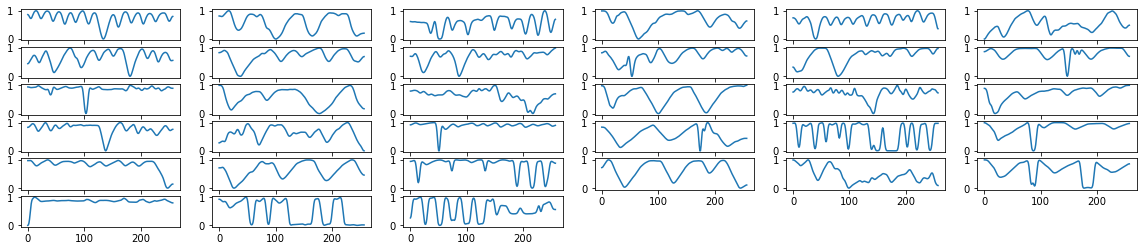

<Figure size 432x288 with 0 Axes>

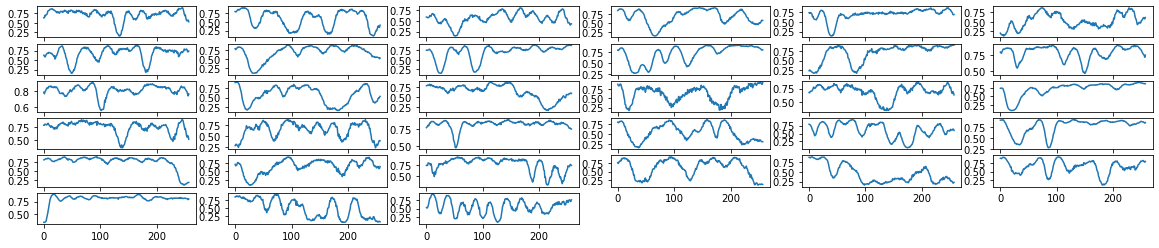

In [29]:
x2_pred = autoencoder2.predict(x2_train)


#plot n samples to compare
n = 33

#plot the original values
plt.figure()
plt.figure(figsize=(20, 4))
for i in range(n):
    plt.subplot(n/5, 6, i+1)
    plt.plot(x2_train[i])
    
#plot the reconstructed values
plt.figure()
plt.figure(figsize=(20, 4))
for i in range(n):
    plt.subplot(n/5, 6, i+1)
    plt.plot(x2_pred[i])

Combine the encoder layer and the classification model:

In [30]:
# leave out person out validation
user_epoch_data = {}
seconds = 30  # time window length
accs_undercomplete2 = []

n = len(idents)
for ident in range(3):
    train_idents = [x for i, x in enumerate(idents) if (i != ident and i != (n-1+ident)%n)]
    validation_idents = [idents[ident]]
    test_idents = [idents[ident-1]]

    xt_train, yt_train = get_data_from_idents(path, train_idents, seconds)
    xt_valid, yt_valid = get_data_from_idents(path, validation_idents, seconds)
    xt_test, yt_test = get_data_from_idents(path, test_idents, seconds)

    x2t_train = xt_train[:,1::step]
    x2t_train = np.apply_along_axis(convolve, 1, x2t_train)

    x2t_valid = xt_valid[:,1::step]
    x2t_valid = np.apply_along_axis(convolve, 1, x2t_valid)

    x2t_test = xt_test[:,1::step]
    x2t_test = np.apply_along_axis(convolve, 1, x2t_test)

    sscaler = StandardScaler()
    sscaler.fit(np.vstack((x2t_train, x2t_test, x2t_valid)))
    x2t_train = sscaler.transform(x2t_train)
    x2t_valid = sscaler.transform(x2t_valid)
    x2t_test = sscaler.transform(x2t_test)

    mmscaler = MinMaxScaler()
    mmscaler.fit(np.vstack((x2t_train, x2t_test, x2t_valid)))
    x2t_train = mmscaler.transform(x2t_train)
    x2t_valid = mmscaler.transform(x2t_valid)
    x2t_test = mmscaler.transform(x2t_test)

    # AE Training
    batch_size = 256
    epochs = 200

    # this model maps an input to its reconstruction
    autoencoder2, encoded = undercomplete_ae(x2_train, 60)
    
    
    print("\n\nAE TRAINING: ", ident)
    sc, curr_acc, epoch_data = model_train(autoencoder2, x2t_train, x2t_train, batch_size, epochs,
                                           x2t_valid, x2t_valid, x2t_test, x2t_test)

    model = classifier(encoded, kernel_size = 16, filters = 16, strides = 1, pool_size = 2, lstm_output_size = 16)

    model = Model(inputs=autoencoder2.inputs, outputs=model)
    model.compile(loss='binary_crossentropy',
                  optimizer='adam',
                  metrics=metrics)

    # Classifier Training
    batch_size = 256
    epochs = 100
    
    print("\n\nCLASSIFICATION TRAINING: ", ident)
    sc, curr_acc, epoch_data = model_train(model, x2t_train, yt_train, batch_size, epochs,
                                           x2t_valid, yt_valid, x2t_test, yt_test)

    accs_undercomplete2.append(curr_acc)
    
    # This code remains from the previous author, copied from __main__()
    epoch_data.history['user_id'] = idents[ident]
    user_epoch_data[idents[ident]] = epoch_data.history

    jsonformat = json.dumps(str(user_epoch_data))
    f = open("./AEOutput/compl2_2_NC_kernel_200_pool_4_filter_64_strides_4_lstm_256.json", "w")
    f.write(jsonformat)
    f.close()
    
# print some statistics
tmp = accs_undercomplete2
print("\n\n")
print("accuracies:")
print("- min:", np.min(tmp))
print("- max:", np.max(tmp))
print("- mean:", np.mean(tmp))



AE TRAINING:  0
Train...
Evaluate...
28/28 [==============================] - 0s 36us/sample - loss: 0.5598 - accuracy: 0.0075 - true_positives: 2863.0000 - false_positives: 0.0000e+00 - true_negatives: 28.0000 - false_negatives: 4333.0000


CLASSIFICATION TRAINING:  0
Train...
Evaluate...
28/28 [==============================] - 0s 71us/sample - loss: 0.7352 - accuracy: 0.6071 - true_positives: 8.0000 - false_positives: 3.0000 - true_negatives: 9.0000 - false_negatives: 8.0000


AE TRAINING:  1
Train...
Evaluate...
34/34 [==============================] - 0s 29us/sample - loss: 0.4625 - accuracy: 0.0081 - true_positives: 7009.0000 - false_positives: 1.0000 - true_negatives: 33.0000 - false_negatives: 1729.0000


CLASSIFICATION TRAINING:  1
Train...
Evaluate...
34/34 [==============================] - 0s 59us/sample - loss: 0.5232 - accuracy: 0.7941 - true_positives: 13.0000 - false_positives: 3.0000 - true_negatives: 14.0000 - false_negatives: 4.0000


AE TRAINING:  2
Train...
Evalu

### Sparse Autoencoders

In [31]:
def sparse_ae(x, encoding_dim=64):
    # Simplest possible autoencoder from https://blog.keras.io/building-autoencoders-in-keras.html

    # this is our input placeholder
    input_data = Input(shape=x[0].shape, name="input")
    dropout = Dropout(0.25, name="dropout") (input_data)
    # "encoded" is the encoded representation of the input
    # add a sparsity constraint
    encoded = Dense(encoding_dim, activation='relu', name="encoded",
                    activity_regularizer=regularizers.l1(10e-5))(dropout)
    
    # "decoded" is the lossy reconstruction of the input
    decoded = Dense(x[0].shape[0], activation='sigmoid', name="decoded")(encoded)

    # this model maps an input to its reconstruction
    autoencoder = Model(input_data, decoded, name="sparse_ae")
    
    # compile the model
    autoencoder.compile(optimizer='adam', loss='binary_crossentropy', metrics=metrics)
    
    return autoencoder, encoded

#### Sparse Autoencoder - Normalized Input Data

Build the autoencoder:

In [32]:
autoencoder, _ = sparse_ae(x_train, 60)

Print the summary of the autoencoder:

Model: "sparse_ae"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input (InputLayer)           [(None, 1290)]            0         
_________________________________________________________________
dropout (Dropout)            (None, 1290)              0         
_________________________________________________________________
encoded (Dense)              (None, 60)                77460     
_________________________________________________________________
decoded (Dense)              (None, 1290)              78690     
Total params: 156,150
Trainable params: 156,150
Non-trainable params: 0
_________________________________________________________________


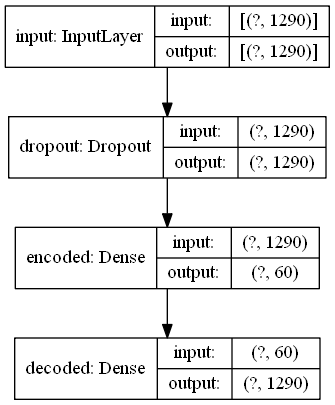

In [33]:
autoencoder.summary()
keras.utils.plot_model(autoencoder, "./AEOutput/sparse_ae.png", show_shapes=True)

Compile and train the model:

In [34]:
# Training
batch_size = 256
epochs = 1000

# Fit the model
autoencoder.fit(x_train, x_train,
                epochs=epochs,
                batch_size=batch_size,
                shuffle=True,
                verbose=0,
                validation_data=(x_test, x_test))
print("Finished Training!", "\nbatch size:", batch_size, "\nepochs:", epochs)

Finished Training! 
batch size: 256 
epochs: 1000


Plot some input data and the corresponding reconstructed data: 

<Figure size 432x288 with 0 Axes>

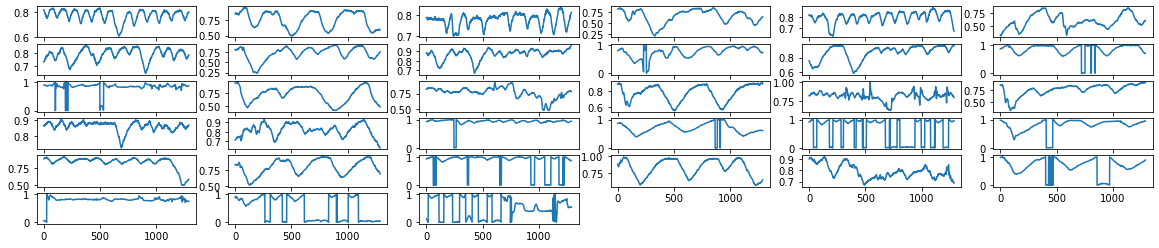

<Figure size 432x288 with 0 Axes>

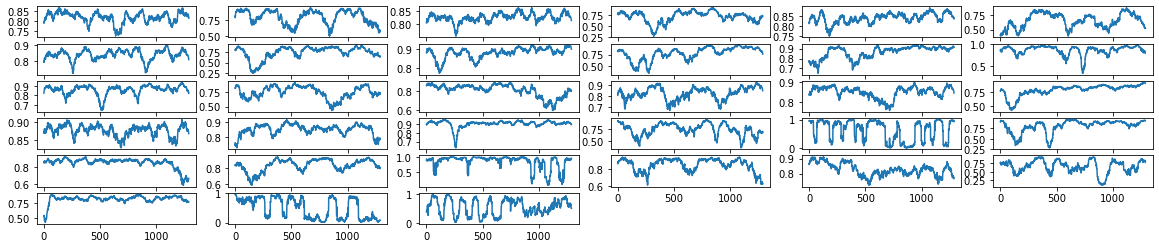

In [35]:
x_pred = autoencoder.predict(x_train)


#plot n samples to compare the input and reconstruction
n = 33

#plot the input values
plt.figure()
plt.figure(figsize=(20, 4))
for i in range(n):
    plt.subplot(n/5, 6, i+1)
    plt.plot(x_train[i])
    
#plot the reconstructed values
plt.figure()
plt.figure(figsize=(20, 4))
for i in range(n):
    plt.subplot(n/5, 6, i+1)
    plt.plot(x_pred[i])

Combine the encoder layer and the classification model:

In [36]:
# leave out person out validation
user_epoch_data = {}
seconds = 30  # time window length
accs_sparse = []

n = len(idents)
for ident in range(3):
    train_idents = [x for i, x in enumerate(idents) if (i != ident and i != (n-1+ident)%n)]
    validation_idents = [idents[ident]]
    test_idents = [idents[ident-1]]

    xt_train, yt_train = get_data_from_idents(path, train_idents, seconds)
    xt_valid, yt_valid = get_data_from_idents(path, validation_idents, seconds)
    xt_test, yt_test = get_data_from_idents(path, test_idents, seconds)

#     xt_train = np.apply_along_axis(normalize, 1, xt_train)
#     xt_valid = np.apply_along_axis(normalize, 1, xt_valid)
#     xt_test = np.apply_along_axis(normalize, 1, xt_test)
    sscaler = StandardScaler()
    sscaler.fit(np.vstack((xt_train, xt_test, xt_valid)))
    xt_train = sscaler.transform(xt_train)
    xt_valid = sscaler.transform(xt_valid)
    xt_test = sscaler.transform(xt_test)

    mmscaler = MinMaxScaler()
    mmscaler.fit(np.vstack((xt_train, xt_test, xt_valid)))
    xt_train = mmscaler.transform(xt_train)
    xt_valid = mmscaler.transform(xt_valid)
    xt_test = mmscaler.transform(xt_test)

    # AE Training
    batch_size = 256
    epochs = 1000

    autoencoder, encoded = sparse_ae(x_train, 60)
    
    print("\n\nAUTOENCODER TRAINING: ", ident)
    sc, curr_acc, epoch_data = model_train(autoencoder, xt_train, xt_train, batch_size, epochs,
                                           xt_valid, xt_valid, xt_test, xt_test)

    model = classifier(encoded, kernel_size = 16, filters = 16, strides = 1, pool_size = 2, lstm_output_size = 16)

    model = Model(inputs=autoencoder.inputs, outputs=model)
    model.compile(loss='binary_crossentropy',
                  optimizer='adam',
                  metrics=metrics)

    # Classifier Training
    batch_size = 256
    epochs = 100
    
    print("\n\nCLASSIFICATION TRAINING: ", ident)
    sc, curr_acc, epoch_data = model_train(model, xt_train, yt_train, batch_size, epochs,
                                           xt_valid, yt_valid, xt_test, yt_test)

    accs_sparse.append(curr_acc)
    
    # This code remains from the previous author, copied from __main__()
    epoch_data.history['user_id'] = idents[ident]
    user_epoch_data[idents[ident]] = epoch_data.history

    jsonformat = json.dumps(str(user_epoch_data))
    f = open("./AEOutput/compl2_2_NC_kernel_200_pool_4_filter_64_strides_4_lstm_256.json", "w")
    f.write(jsonformat)
    f.close()
    
# print some statistics
tmp = accs_sparse
print("\n\n")
print("accuracies:")
print("- min:", np.min(tmp))
print("- max:", np.max(tmp))
print("- mean:", np.mean(tmp))



AUTOENCODER TRAINING:  0
Train...
Evaluate...
28/28 [==============================] - 0s 71us/sample - loss: 0.5211 - accuracy: 2.4917e-04 - true_positives: 415.0000 - false_positives: 1.0000 - true_negatives: 7.0000 - false_negatives: 35697.0000


CLASSIFICATION TRAINING:  0
Train...
Evaluate...
28/28 [==============================] - 0s 71us/sample - loss: 0.6106 - accuracy: 0.7143 - true_positives: 14.0000 - false_positives: 6.0000 - true_negatives: 6.0000 - false_negatives: 2.0000


AUTOENCODER TRAINING:  1
Train...
Evaluate...
34/34 [==============================] - 0s 59us/sample - loss: 0.4938 - accuracy: 0.0031 - true_positives: 40112.0000 - false_positives: 71.0000 - true_negatives: 53.0000 - false_negatives: 3624.0000


CLASSIFICATION TRAINING:  1
Train...
Evaluate...
34/34 [==============================] - 0s 59us/sample - loss: 0.5668 - accuracy: 0.7647 - true_positives: 13.0000 - false_positives: 4.0000 - true_negatives: 13.0000 - false_negatives: 4.0000


AUTOENCODE

#### Sparse Autoencoder - Shortened Input Data

Build the autoencoder:

In [37]:
autencoder2 = sparse_ae(x2_train, 24)

Print the summary of the autoencoder:

Model: "model_12"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input (InputLayer)           [(None, 258)]             0         
_________________________________________________________________
dropout (Dropout)            (None, 258)               0         
_________________________________________________________________
encoded (Dense)              (None, 60)                15540     
_________________________________________________________________
decoded (Dense)              (None, 258)               15738     
Total params: 31,278
Trainable params: 31,278
Non-trainable params: 0
_________________________________________________________________


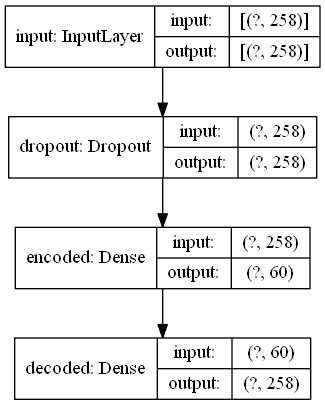

In [38]:
autoencoder2.summary()
keras.utils.plot_model(autoencoder2, "./AEOutput/sparse_ae2.png", show_shapes=True)

Train the model:

In [39]:
# Training
batch_size = 256
epochs = 200

# Fit the model
autoencoder2.fit(x2_train, x2_train,
                epochs=epochs,
                batch_size=batch_size,
                shuffle=True,
                verbose=0,
                validation_data=(x2_test, x2_test))
print("Finished Training!", "\nbatch size:", batch_size, "\nepochs:", epochs)

Finished Training! 
batch size: 256 
epochs: 200


Plot some input data and the corresponding reconstructed data:

<Figure size 432x288 with 0 Axes>

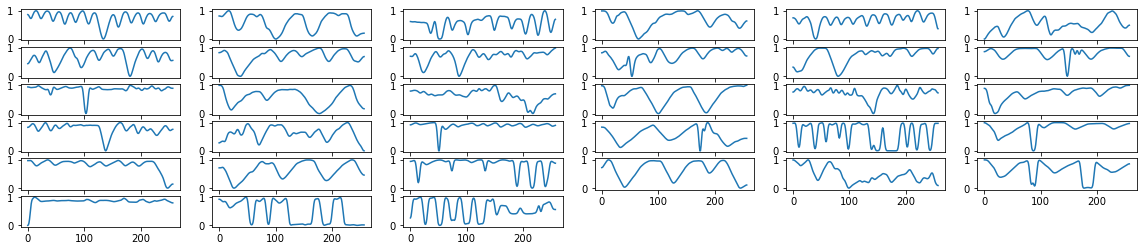

<Figure size 432x288 with 0 Axes>

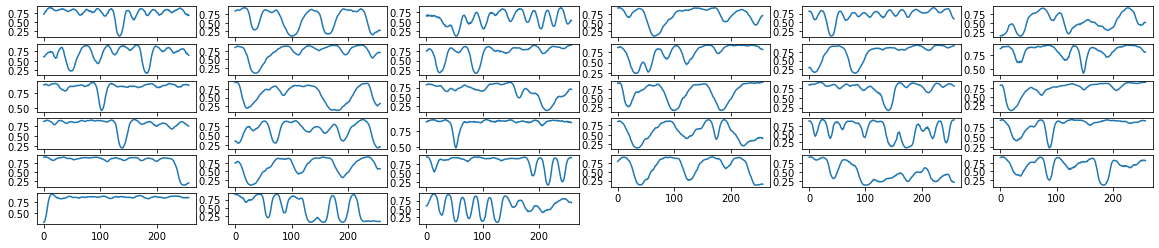

In [40]:
x2_pred = autoencoder2.predict(x2_train)


#plot n samples to compare
n = 33

#plot the original values
plt.figure()
plt.figure(figsize=(20, 4))
for i in range(n):
    plt.subplot(n/5, 6, i+1)
    plt.plot(x2_train[i])
    
#plot the reconstructed values
plt.figure()
plt.figure(figsize=(20, 4))
for i in range(n):
    plt.subplot(n/5, 6, i+1)
    plt.plot(x2_pred[i])

Combine the encoder layer and the classification model:

In [41]:
# leave out person out validation
user_epoch_data = {}
seconds = 30  # time window length

accs_sparse2 = []

n = len(idents)
for ident in range(3):
    train_idents = [x for i, x in enumerate(idents) if (i != ident and i != (n-1+ident)%n)]
    validation_idents = [idents[ident]]
    test_idents = [idents[ident-1]]

    xt_train, yt_train = get_data_from_idents(path, train_idents, seconds)
    xt_valid, yt_valid = get_data_from_idents(path, validation_idents, seconds)
    xt_test, yt_test = get_data_from_idents(path, test_idents, seconds)

    x2t_train = xt_train[:,1::step]
    x2t_train = np.apply_along_axis(convolve, 1, x2t_train)

    x2t_valid = xt_valid[:,1::step]
    x2t_valid = np.apply_along_axis(convolve, 1, x2t_valid)

    x2t_test = xt_test[:,1::step]
    x2t_test = np.apply_along_axis(convolve, 1, x2t_test)

    sscaler = StandardScaler()
    sscaler.fit(np.vstack((x2t_train, x2t_test, x2t_valid)))
    x2t_train = sscaler.transform(x2t_train)
    x2t_valid = sscaler.transform(x2t_valid)
    x2t_test = sscaler.transform(x2t_test)

    mmscaler = MinMaxScaler()
    mmscaler.fit(np.vstack((x2t_train, x2t_test, x2t_valid)))
    x2t_train = mmscaler.transform(x2t_train)
    x2t_valid = mmscaler.transform(x2t_valid)
    x2t_test = mmscaler.transform(x2t_test)

    # AE Training
    batch_size = 256
    epochs = 200

    # this model maps an input to its reconstruction
    autoencoder2, encoded = sparse_ae(x2_train, 24)
    
    
    print("\n\nAE TRAINING: ", ident)
    sc, curr_acc, epoch_data = model_train(autoencoder2, x2t_train, x2t_train, batch_size, epochs,
                                           x2t_valid, x2t_valid, x2t_test, x2t_test)

    model = classifier(encoded, kernel_size = 16, filters = 16, strides = 1, pool_size = 2, lstm_output_size = 16)

    model = Model(inputs=autoencoder2.inputs, outputs=model)
    model.compile(loss='binary_crossentropy',
                  optimizer='adam',
                  metrics=metrics)

    # Classifier Training
    batch_size = 256
    epochs = 100
    
    print("\n\nCLASSIFICATION TRAINING: ", ident)
    sc, curr_acc, epoch_data = model_train(model, x2t_train, yt_train, batch_size, epochs,
                                           x2t_valid, yt_valid, x2t_test, yt_test)

    accs_sparse2.append(curr_acc)
    
    # This code remains from the previous author, copied from __main__()
    epoch_data.history['user_id'] = idents[ident]
    user_epoch_data[idents[ident]] = epoch_data.history

    jsonformat = json.dumps(str(user_epoch_data))
    f = open("./AEOutput/compl2_2_NC_kernel_200_pool_4_filter_64_strides_4_lstm_256.json", "w")
    f.write(jsonformat)
    f.close()
    
# print some statistics
tmp = accs_sparse2
print("\n\n")
print("accuracies:")
print("- min:", np.min(tmp))
print("- max:", np.max(tmp))
print("- mean:", np.mean(tmp))



AE TRAINING:  0
Train...
Evaluate...
28/28 [==============================] - 0s 36us/sample - loss: 0.5778 - accuracy: 0.0069 - true_positives: 2748.0000 - false_positives: 3.0000 - true_negatives: 25.0000 - false_negatives: 4448.0000


CLASSIFICATION TRAINING:  0
Train...
Evaluate...
28/28 [==============================] - 0s 72us/sample - loss: 0.6163 - accuracy: 0.7500 - true_positives: 12.0000 - false_positives: 3.0000 - true_negatives: 9.0000 - false_negatives: 4.0000


AE TRAINING:  1
Train...
Evaluate...
34/34 [==============================] - 0s 59us/sample - loss: 0.4976 - accuracy: 0.0078 - true_positives: 7085.0000 - false_positives: 4.0000 - true_negatives: 30.0000 - false_negatives: 1653.0000


CLASSIFICATION TRAINING:  1
Train...
Evaluate...
34/34 [==============================] - 0s 59us/sample - loss: 0.6228 - accuracy: 0.7059 - true_positives: 15.0000 - false_positives: 8.0000 - true_negatives: 9.0000 - false_negatives: 2.0000


AE TRAINING:  2
Train...
Evaluate.

### Deep Autoencoders 
from https://blog.keras.io/building-autoencoders-in-keras.html

In [42]:
def deep_ae(x, enc_layers=[512,256], encoding_dim=64, dec_layers=[256,512]):
    # From https://www.tensorflow.org/guide/keras/functional#use_the_same_graph_of_layers_to_define_multiple_models
    encoded_input = keras.Input(shape=x[0].shape, name="normalized_signal")
    model = Dropout(0.25, name="dropout", autocast=False)(encoded_input)
    for i in enumerate(enc_layers):
        model = Dense(i[1], activation="relu", name="dense_enc_" + str(i[0]+1))(model)
    encoded_output = Dense(encoding_dim, activation="relu", name="encoded_signal")(model)

    encoded = encoded_output

    model = layers.Dense(dec_layers[0], activation="sigmoid", name="dense_dec_1")(encoded_output)
    for i in enumerate(dec_layers[1:]):
        model = Dense(i[1], activation="sigmoid", name="dense_dec_" + str(i[0]+2))(model)
    decoded_output = Dense(x[0].shape[0], activation="sigmoid", name="reconstructed_signal")(model)
    
    autoencoder = Model(encoded_input, decoded_output, name="autoencoder")
    
    # compile the model
    autoencoder.compile(optimizer='adam', loss='binary_crossentropy', metrics=metrics)
    
    return autoencoder, encoded

#### Deep Autoencoder - Normalized Input Data

Build the autoencoder:

In [43]:
autoencoder, _ = deep_ae(x=x_train, enc_layers=[512,256], encoding_dim=64, dec_layers=[256, 512])

Print the summary of the autoencoder:

Model: "autoencoder"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
normalized_signal (InputLaye [(None, 1290)]            0         
_________________________________________________________________
dropout (Dropout)            (None, 1290)              0         
_________________________________________________________________
dense_enc_1 (Dense)          (None, 512)               660992    
_________________________________________________________________
dense_enc_2 (Dense)          (None, 256)               131328    
_________________________________________________________________
encoded_signal (Dense)       (None, 64)                16448     
_________________________________________________________________
dense_dec_1 (Dense)          (None, 256)               16640     
_________________________________________________________________
dense_dec_2 (Dense)          (None, 512)               

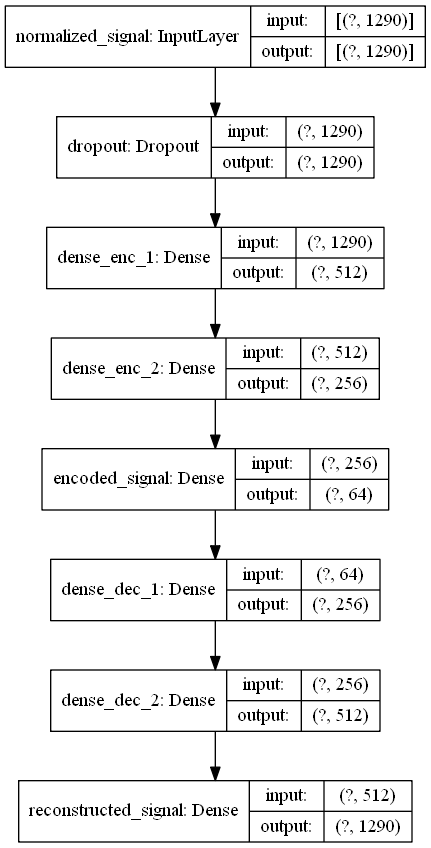

In [44]:
autoencoder.summary()
keras.utils.plot_model(autoencoder, "./AEOutput/deep_ae.png", show_shapes=True)

Train the model:

In [45]:
# Training
batch_size = 256
epochs = 1000

autoencoder.fit(x_train, x_train,
                epochs=epochs,
                batch_size=batch_size,
                shuffle=True,
                verbose=0,
                validation_data=(x_test, x_test))

print("Finished Training!", "\nbatch size:", batch_size, "\nepochs:", epochs)

Finished Training! 
batch size: 256 
epochs: 1000


Plot some input data and the corresponding reconstructed data:

<Figure size 432x288 with 0 Axes>

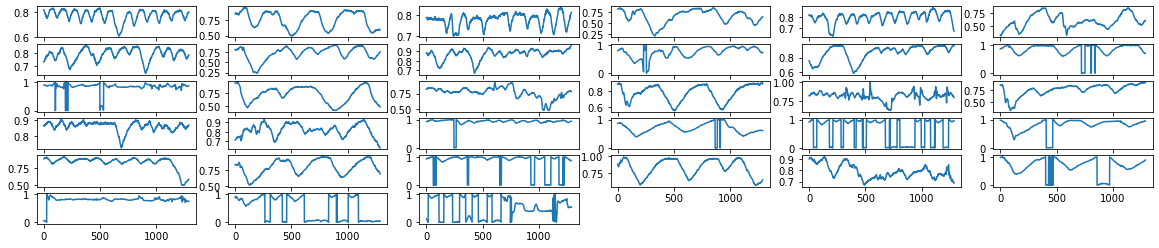

<Figure size 432x288 with 0 Axes>

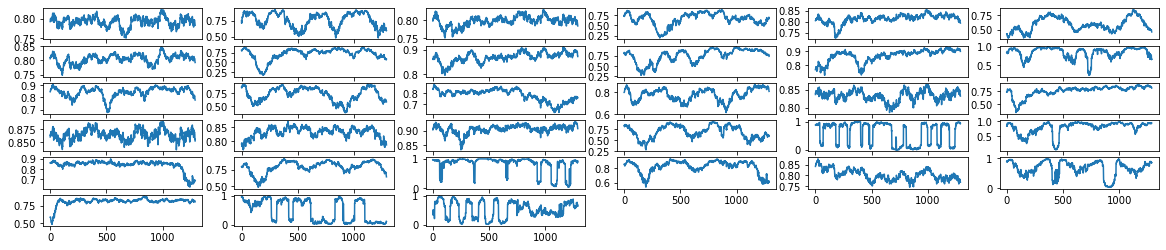

In [46]:
x_pred = autoencoder.predict(x_train)


#plot n samples to compare
n = 33

#plot the original values
plt.figure()
plt.figure(figsize=(20, 4))
for i in range(n):
    plt.subplot(n/5, 6, i+1)
    plt.plot(x_train[i])
    
#plot the reconstructed values
plt.figure()
plt.figure(figsize=(20, 4))
for i in range(n):
    plt.subplot(n/5, 6, i+1)
    plt.plot(x_pred[i])

Combine the encoder layer and the classification model:

In [47]:
# leave out person out validation
user_epoch_data = {}
seconds = 30  # time window length

accs_deep = []

n = len(idents)
for ident in range(3):
    train_idents = [x for i, x in enumerate(idents) if (i != ident and i != (n-1+ident)%n)]
    validation_idents = [idents[ident]]
    test_idents = [idents[ident-1]]

    xt_train, yt_train = get_data_from_idents(path, train_idents, seconds)
    xt_valid, yt_valid = get_data_from_idents(path, validation_idents, seconds)
    xt_test, yt_test = get_data_from_idents(path, test_idents, seconds)

#     xt_train = np.apply_along_axis(normalize, 1, xt_train)
#     xt_valid = np.apply_along_axis(normalize, 1, xt_valid)
#     xt_test = np.apply_along_axis(normalize, 1, xt_test)
    sscaler = StandardScaler()
    sscaler.fit(np.vstack((xt_train, xt_test, xt_valid)))
    xt_train = sscaler.transform(xt_train)
    xt_valid = sscaler.transform(xt_valid)
    xt_test = sscaler.transform(xt_test)

    mmscaler = MinMaxScaler()
    mmscaler.fit(np.vstack((xt_train, xt_test, xt_valid)))
    xt_train = mmscaler.transform(xt_train)
    xt_valid = mmscaler.transform(xt_valid)
    xt_test = mmscaler.transform(xt_test)

    # AE Training
    batch_size = 256
    epochs = 1000
    
    autoencoder, encoded = deep_ae(x_train, [512, 256], 64, [256, 512])
    
    print("\n\nAE TRAINING: ", ident)
    sc, curr_acc, epoch_data = model_train(autoencoder, xt_train, xt_train, batch_size, epochs,
                                           xt_valid, xt_valid, xt_test, xt_test)

    model = classifier(encoded, kernel_size = 16, filters = 16, strides = 1, pool_size = 2, lstm_output_size = 16)

    model = Model(inputs=autoencoder.inputs, outputs=model)
    model.compile(loss='binary_crossentropy',
                  optimizer='adam',
                  metrics=metrics)

    # Classifier Training
    batch_size = 256
    epochs = 100
    
    print("\n\nCLASSIFICATION TRAINING: ", ident)
    sc, curr_acc, epoch_data = model_train(model, xt_train, yt_train, batch_size, epochs,
                                           xt_valid, yt_valid, xt_test, yt_test)

    accs_deep.append(curr_acc)
    
    epoch_data.history['user_id'] = idents[ident]
    user_epoch_data[idents[ident]] = epoch_data.history

    jsonformat = json.dumps(str(user_epoch_data))
    f = open("./AEOutput/compl2_2_NC_kernel_200_pool_4_filter_64_strides_4_lstm_256.json", "w")
    f.write(jsonformat)
    f.close()
    
# print some statistics
tmp = accs_deep
print("\n\n")
print("accuracies:")
print("- min:", np.min(tmp))
print("- max:", np.max(tmp))
print("- mean:", np.mean(tmp))



AE TRAINING:  0
Train...
Evaluate...
28/28 [==============================] - 0s 214us/sample - loss: 0.5208 - accuracy: 2.2148e-04 - true_positives: 361.0000 - false_positives: 0.0000e+00 - true_negatives: 8.0000 - false_negatives: 35751.0000


CLASSIFICATION TRAINING:  0
Train...
Evaluate...
28/28 [==============================] - 0s 107us/sample - loss: 0.6652 - accuracy: 0.7143 - true_positives: 10.0000 - false_positives: 2.0000 - true_negatives: 10.0000 - false_negatives: 6.0000


AE TRAINING:  1
Train...
Evaluate...
34/34 [==============================] - 0s 176us/sample - loss: 0.4939 - accuracy: 0.0030 - true_positives: 41008.0000 - false_positives: 93.0000 - true_negatives: 31.0000 - false_negatives: 2728.0000


CLASSIFICATION TRAINING:  1
Train...
Evaluate...
34/34 [==============================] - 0s 88us/sample - loss: 0.6223 - accuracy: 0.6176 - true_positives: 6.0000 - false_positives: 2.0000 - true_negatives: 15.0000 - false_negatives: 11.0000


AE TRAINING:  2
Trai

#### Deep Autoencoder - Shortened Input Data

Build the autoencoder:

In [48]:
autoencoder2, _ = deep_ae(x2_train, [156,128], 64, [128, 156])

Print the summary of the autoencoder:

Model: "autoencoder"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
normalized_signal (InputLaye [(None, 258)]             0         
_________________________________________________________________
dropout (Dropout)            (None, 258)               0         
_________________________________________________________________
dense_enc_1 (Dense)          (None, 156)               40404     
_________________________________________________________________
dense_enc_2 (Dense)          (None, 128)               20096     
_________________________________________________________________
encoded_signal (Dense)       (None, 64)                8256      
_________________________________________________________________
dense_dec_1 (Dense)          (None, 128)               8320      
_________________________________________________________________
dense_dec_2 (Dense)          (None, 156)               

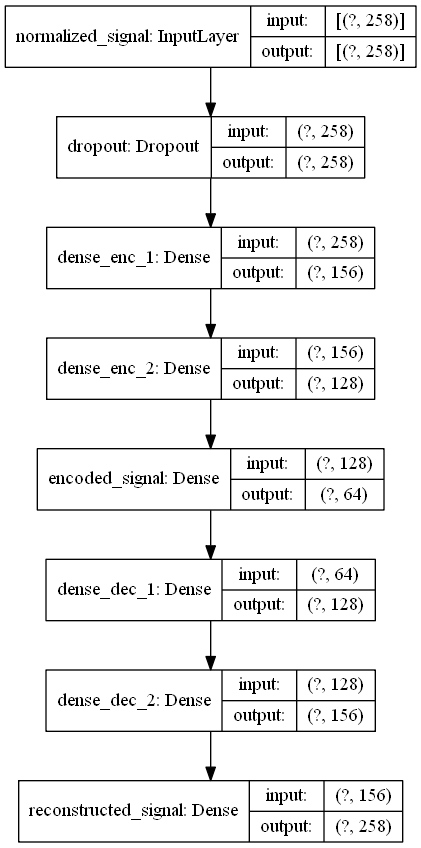

In [49]:
autoencoder2.summary()
keras.utils.plot_model(autoencoder2, "./AEOutput/deep_ae2.png", show_shapes=True)

Train the model:

In [50]:
# Training
batch_size = 256
epochs = 1000

autoencoder2.fit(x2_train, x2_train,
                epochs=epochs,
                batch_size=batch_size,
                shuffle=True,
                verbose=0,
                validation_data=(x2_test, x2_test))

print("Finished Training!", "\nbatch size:", batch_size, "\nepochs:", epochs)

Finished Training! 
batch size: 256 
epochs: 1000


Plot some input data and the corresponding reconstructed data:

<Figure size 432x288 with 0 Axes>

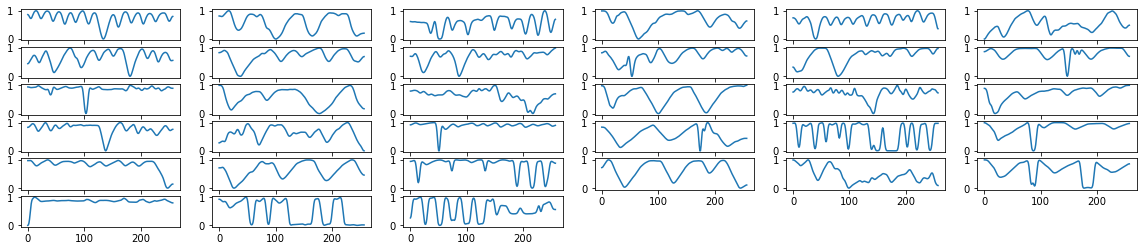

<Figure size 432x288 with 0 Axes>

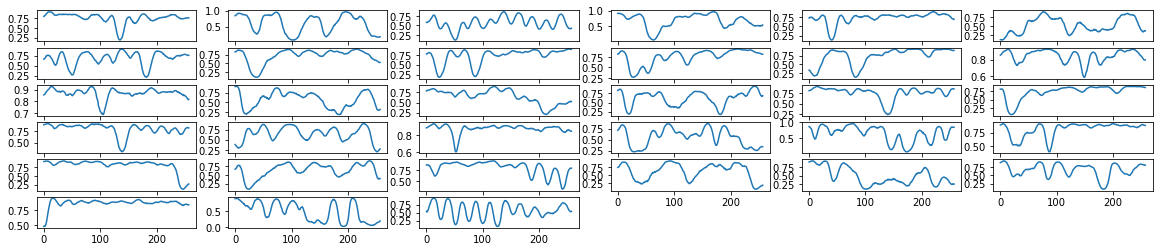

In [51]:
x2_pred = autoencoder2.predict(x2_train)


#plot n samples to compare
n = 33

#plot the original values
plt.figure()
plt.figure(figsize=(20, 4))
for i in range(n):
    plt.subplot(n/5, 6, i+1)
    plt.plot(x2_train[i])
    
#plot the reconstructed values
plt.figure()
plt.figure(figsize=(20, 4))
for i in range(n):
    plt.subplot(n/5, 6, i+1)
    plt.plot(x2_pred[i])

Combine the encoder layer and the classification model:

In [52]:
# leave out person out validation
user_epoch_data = {}
seconds = 30  # time window length

accs_deep2 = []

n = len(idents)
for ident in range(3):
    train_idents = [x for i, x in enumerate(idents) if (i != ident and i != (n-1+ident)%n)]
    validation_idents = [idents[ident]]
    test_idents = [idents[ident-1]]

    xt_train, yt_train = get_data_from_idents(path, train_idents, seconds)
    xt_valid, yt_valid = get_data_from_idents(path, validation_idents, seconds)
    xt_test, yt_test = get_data_from_idents(path, test_idents, seconds)

    x2t_train = xt_train[:,1::step]
    x2t_train = np.apply_along_axis(convolve, 1, x2t_train)

    x2t_valid = xt_valid[:,1::step]
    x2t_valid = np.apply_along_axis(convolve, 1, x2t_valid)

    x2t_test = xt_test[:,1::step]
    x2t_test = np.apply_along_axis(convolve, 1, x2t_test)

    sscaler = StandardScaler()
    sscaler.fit(np.vstack((x2t_train, x2t_test, x2t_valid)))
    x2t_train = sscaler.transform(x2t_train)
    x2t_valid = sscaler.transform(x2t_valid)
    x2t_test = sscaler.transform(x2t_test)

    mmscaler = MinMaxScaler()
    mmscaler.fit(np.vstack((x2t_train, x2t_test, x2t_valid)))
    x2t_train = mmscaler.transform(x2t_train)
    x2t_valid = mmscaler.transform(x2t_valid)
    x2t_test = mmscaler.transform(x2t_test)

    # AE Training
    batch_size = 256
    epochs = 1000

    # this model maps an input to its reconstruction
    autoencoder2, encoded = deep_ae(x2_train, [128,64], 32, [64, 128])
    
    
    print("\n\nAE TRAINING: ", ident)
    sc, curr_acc, epoch_data = model_train(autoencoder2, x2t_train, x2t_train, batch_size, epochs,
                                           x2t_valid, x2t_valid, x2t_test, x2t_test)

    model = classifier(encoded, kernel_size = 16, filters = 16, strides = 1, pool_size = 2, lstm_output_size = 16)

    model = Model(inputs=autoencoder2.inputs, outputs=model)
    model.compile(loss='binary_crossentropy',
                  optimizer='adam',
                  metrics=metrics)

    # Classifier Training
    batch_size = 256
    epochs = 100
    
    print("\n\nCLASSIFICATION TRAINING: ", ident)
    sc, curr_acc, epoch_data = model_train(model, x2t_train, yt_train, batch_size, epochs,
                                           x2t_valid, yt_valid, x2t_test, yt_test)

    accs_deep2.append(curr_acc)
    
    # This code remains from the previous author, copied from __main__()
    epoch_data.history['user_id'] = idents[ident]
    user_epoch_data[idents[ident]] = epoch_data.history

    jsonformat = json.dumps(str(user_epoch_data))
    f = open("./AEOutput/compl2_2_NC_kernel_200_pool_4_filter_64_strides_4_lstm_256.json", "w")
    f.write(jsonformat)
    f.close()
    
# print some statistics
tmp = accs_deep2
print("\n\n")
print("accuracies:")
print("- min:", np.min(tmp))
print("- max:", np.max(tmp))
print("- mean:", np.mean(tmp))



AE TRAINING:  0
Train...
Evaluate...
28/28 [==============================] - 0s 71us/sample - loss: 0.5810 - accuracy: 0.0062 - true_positives: 2710.0000 - false_positives: 3.0000 - true_negatives: 25.0000 - false_negatives: 4486.0000


CLASSIFICATION TRAINING:  0
Train...
Evaluate...
28/28 [==============================] - 0s 143us/sample - loss: 0.7629 - accuracy: 0.6429 - true_positives: 8.0000 - false_positives: 2.0000 - true_negatives: 10.0000 - false_negatives: 8.0000


AE TRAINING:  1
Train...
Evaluate...
34/34 [==============================] - 0s 87us/sample - loss: 0.5188 - accuracy: 0.0071 - true_positives: 7224.0000 - false_positives: 10.0000 - true_negatives: 24.0000 - false_negatives: 1514.0000


CLASSIFICATION TRAINING:  1
Train...
Evaluate...
34/34 [==============================] - 0s 88us/sample - loss: 0.5713 - accuracy: 0.7059 - true_positives: 14.0000 - false_positives: 7.0000 - true_negatives: 10.0000 - false_negatives: 3.0000


AE TRAINING:  2
Train...
Evalua

### Contractive Autoencoders
From: https://wiseodd.github.io/techblog/2016/12/05/contractive-autoencoder/

In [53]:
import tensorflow.keras.backend as K

In [54]:
# define a function to be able to access the autoencoder in the loss funciton
def loss_with_params(autoencoder):
    # loss function from https://wiseodd.github.io/techblog/2016/12/05/contractive-autoencoder/
    def contractive_loss(y_pred, y_true):

        lam = 1e-4
        mse = K.mean(K.square(y_true - y_pred), axis=1)

        W = K.variable(value=autoencoder.get_layer('encoded').get_weights()[0])  # N x N_hidden
        W = K.transpose(W)  # N_hidden x N
        h = autoencoder.get_layer('encoded').output
        dh = h * (1 - h)  # N_batch x N_hidden

        # N_batch x N_hidden * N_hidden x 1 = N_batch x 1
        contractive = lam * K.sum(dh**2 * K.sum(W**2, axis=1), axis=1)

        return mse + contractive
    return contractive_loss

In [55]:
def contractive_ae(x, encoding_dim=64):
    # From https://wiseodd.github.io/techblog/2016/12/05/contractive-autoencoder/

    inputs = Input(shape=x[0].shape, name="input")
    encoded = Dense(encoding_dim, activation='sigmoid', name='encoded')(inputs)
    outputs = Dense(x[0].shape[0], activation='linear', name="output")(encoded)

    autoencoder = Model(inputs, outputs, name="autoencoder")
    
    # compile the model
    autoencoder.compile(optimizer='adam', loss=loss_with_params(autoencoder), metrics=metrics)
    
    return autoencoder, encoded

#### Contrative Autoencoder - Normalized Input Data

In [56]:
autoencoder, _ = contractive_ae(x_train, 60)

Print the summary of the autoencoder:

Model: "autoencoder"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input (InputLayer)           [(None, 1290)]            0         
_________________________________________________________________
encoded (Dense)              (None, 60)                77460     
_________________________________________________________________
output (Dense)               (None, 1290)              78690     
Total params: 156,150
Trainable params: 156,150
Non-trainable params: 0
_________________________________________________________________


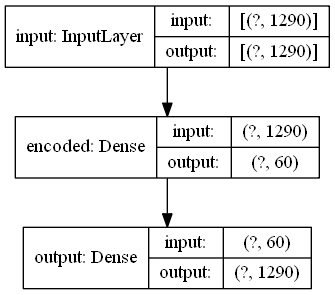

In [57]:
autoencoder.summary()
keras.utils.plot_model(autoencoder, "./AEOutput/contractive_ae.png", show_shapes=True)

Trian the model:

In [58]:
# Training
batch_size = 256
epochs = 1000

# Fit the model
autoencoder.fit(x_train, x_train,
                epochs=epochs,
                batch_size=batch_size,
                shuffle=True,
                verbose=0,
                validation_data=(x_test, x_test))
print("Finished Training!", "\nbatch size:", batch_size, "\nepochs:", epochs)

Finished Training! 
batch size: 256 
epochs: 1000


Plot some input data and the corresponding reconstructed data:

<Figure size 432x288 with 0 Axes>

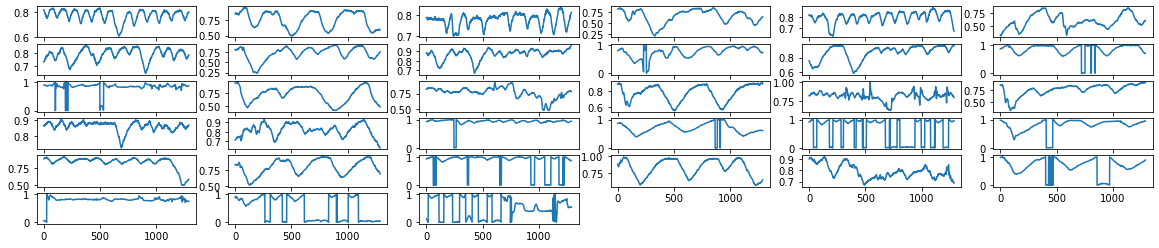

<Figure size 432x288 with 0 Axes>

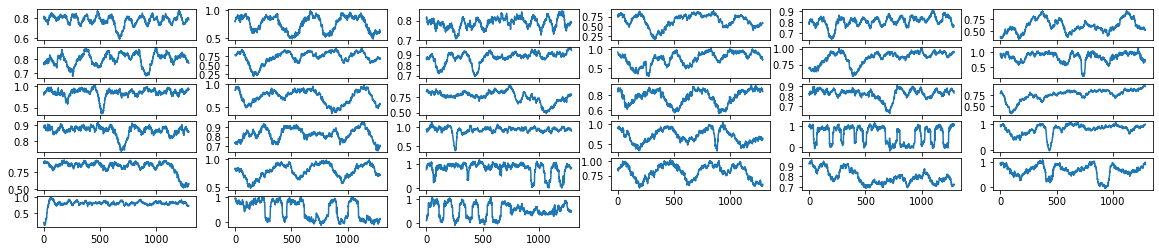

In [59]:
x_pred = autoencoder.predict(x_train)


#plot n samples to compare
n = 33

#plot the original values
plt.figure()
plt.figure(figsize=(20, 4))
for i in range(n):
    plt.subplot(n/5, 6, i+1)
    plt.plot(x_train[i])
    
#plot the reconstructed values
plt.figure()
plt.figure(figsize=(20, 4))
for i in range(n):
    plt.subplot(n/5, 6, i+1)
    plt.plot(x_pred[i])

Combine the encoder layer and the classification model:

In [60]:
# leave out person out validation
user_epoch_data = {}
seconds = 30  # time window length
accs_contractive = []

n = len(idents)
for ident in range(3):
    train_idents = [x for i, x in enumerate(idents) if (i != ident and i != (n-1+ident)%n)]
    validation_idents = [idents[ident]]
    test_idents = [idents[ident-1]]

    xt_train, yt_train = get_data_from_idents(path, train_idents, seconds)
    xt_valid, yt_valid = get_data_from_idents(path, validation_idents, seconds)
    xt_test, yt_test = get_data_from_idents(path, test_idents, seconds)

#     xt_train = np.apply_along_axis(normalize, 1, xt_train)
#     xt_valid = np.apply_along_axis(normalize, 1, xt_valid)
#     xt_test = np.apply_along_axis(normalize, 1, xt_test)
    sscaler = StandardScaler()
    sscaler.fit(np.vstack((xt_train, xt_test, xt_valid)))
    xt_train = sscaler.transform(xt_train)
    xt_valid = sscaler.transform(xt_valid)
    xt_test = sscaler.transform(xt_test)

    mmscaler = MinMaxScaler()
    mmscaler.fit(np.vstack((xt_train, xt_test, xt_valid)))
    xt_train = mmscaler.transform(xt_train)
    xt_valid = mmscaler.transform(xt_valid)
    xt_test = mmscaler.transform(xt_test)

    # AE Training
    batch_size = 256
    epochs = 1000

    autoencoder, encoded = contractive_ae(x_train, 60)
    
    print("\n\nAUTOENCODER TRAINING: ", ident)
    sc, curr_acc, epoch_data = model_train(autoencoder, xt_train, xt_train, batch_size, epochs,
                                           xt_valid, xt_valid, xt_test, xt_test)
    
    model = classifier(encoded, kernel_size = 16, filters = 16, strides = 1, pool_size = 2, lstm_output_size = 16)

    model = Model(inputs=autoencoder.inputs, outputs=model)
    model.compile(loss='binary_crossentropy',
                  optimizer='adam',
                  metrics=metrics)

    # Classifier Training
    batch_size = 256
    epochs = 100
    
    print("\n\nCLASSIFICATION TRAINING: ", ident)
    sc, curr_acc, epoch_data = model_train(model, xt_train, yt_train, batch_size, epochs,
                                           xt_valid, yt_valid, xt_test, yt_test)

    accs_contractive.append(curr_acc)
    
    # This code remains from the previous author, copied from __main__()
    epoch_data.history['user_id'] = idents[ident]
    user_epoch_data[idents[ident]] = epoch_data.history

    jsonformat = json.dumps(str(user_epoch_data))
    f = open("./AEOutput/compl2_2_NC_kernel_200_pool_4_filter_64_strides_4_lstm_256.json", "w")
    f.write(jsonformat)
    f.close()
    
# print some statistics
tmp = accs_contractive
print("\n\n")
print("accuracies:")
print("- min:", np.min(tmp))
print("- max:", np.max(tmp))
print("- mean:", np.mean(tmp))



AUTOENCODER TRAINING:  0
Train...
Evaluate...
28/28 [==============================] - 0s 178us/sample - loss: 0.0049 - accuracy: 0.0000e+00 - true_positives: 658.0000 - false_positives: 3.0000 - true_negatives: 5.0000 - false_negatives: 35454.0000


CLASSIFICATION TRAINING:  0
Train...
Evaluate...
28/28 [==============================] - 0s 250us/sample - loss: 0.5450 - accuracy: 0.7500 - true_positives: 14.0000 - false_positives: 5.0000 - true_negatives: 7.0000 - false_negatives: 2.0000


AUTOENCODER TRAINING:  1
Train...
Evaluate...
34/34 [==============================] - 0s 146us/sample - loss: 0.0121 - accuracy: 0.0000e+00 - true_positives: 39659.0000 - false_positives: 27.0000 - true_negatives: 97.0000 - false_negatives: 4077.0000


CLASSIFICATION TRAINING:  1
Train...
Evaluate...
34/34 [==============================] - 0s 117us/sample - loss: 0.5310 - accuracy: 0.7059 - true_positives: 16.0000 - false_positives: 9.0000 - true_negatives: 8.0000 - false_negatives: 1.0000


AUT

### Contractive Autoencoder - Shortened Input Data

Build the autoencoder:

In [61]:
autoencoder2, _ = contractive_ae(x2_train, 24)

Print the summary of the autoencoder:

Model: "autoencoder"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input (InputLayer)           [(None, 258)]             0         
_________________________________________________________________
encoded (Dense)              (None, 24)                6216      
_________________________________________________________________
output (Dense)               (None, 258)               6450      
Total params: 12,666
Trainable params: 12,666
Non-trainable params: 0
_________________________________________________________________


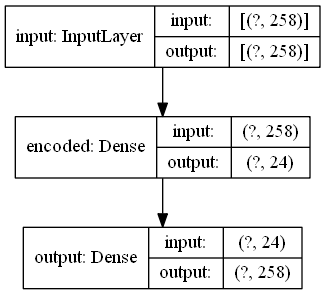

In [62]:
autoencoder2.summary()
keras.utils.plot_model(autoencoder2, "./AEOutput/contractive_ae2.png", show_shapes=True)

Train the model:

In [63]:
# Training
batch_size = 256
epochs = 1000

# Fit the model
autoencoder2.fit(x2_train, x2_train,
                epochs=epochs,
                batch_size=batch_size,
                shuffle=True,
                verbose=0,
                validation_data=(x2_test, x2_test))
print("Finished Training!", "\nbatch size:", batch_size, "\nepochs:", epochs)

Finished Training! 
batch size: 256 
epochs: 1000


Plot some input data and the corresponding reconstructed data:

<Figure size 432x288 with 0 Axes>

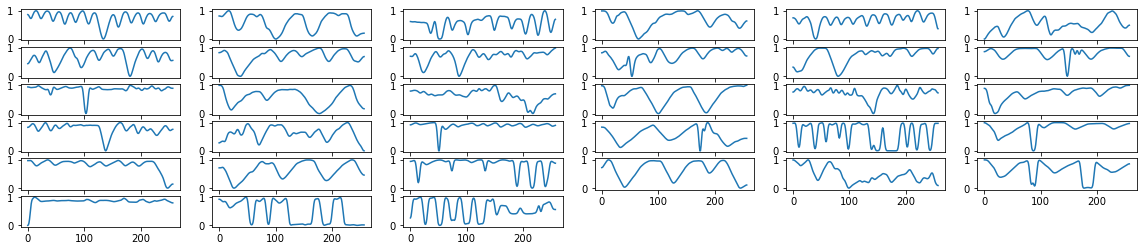

<Figure size 432x288 with 0 Axes>

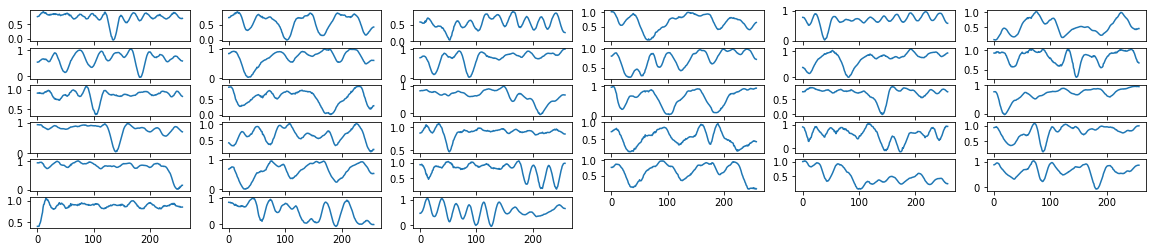

In [64]:
x2_pred = autoencoder2.predict(x2_train)


#plot n samples to compare
n = 33

#plot the original values
plt.figure()
plt.figure(figsize=(20, 4))
for i in range(n):
    plt.subplot(n/5, 6, i+1)
    plt.plot(x2_train[i])
    
#plot the reconstructed values
plt.figure()
plt.figure(figsize=(20, 4))
for i in range(n):
    plt.subplot(n/5, 6, i+1)
    plt.plot(x2_pred[i])

Combine the encoder layer and the classification model:

In [65]:
# leave out person out validation
user_epoch_data = {}
seconds = 30  # time window length
accs_contractive2 = []

n = len(idents)
for ident in range(3):
    train_idents = [x for i, x in enumerate(idents) if (i != ident and i != (n-1+ident)%n)]
    validation_idents = [idents[ident]]
    test_idents = [idents[ident-1]]

    xt_train, yt_train = get_data_from_idents(path, train_idents, seconds)
    xt_valid, yt_valid = get_data_from_idents(path, validation_idents, seconds)
    xt_test, yt_test = get_data_from_idents(path, test_idents, seconds)

    x2t_train = xt_train[:,1::step]
    x2t_train = np.apply_along_axis(convolve, 1, x2t_train)

    x2t_valid = xt_valid[:,1::step]
    x2t_valid = np.apply_along_axis(convolve, 1, x2t_valid)

    x2t_test = xt_test[:,1::step]
    x2t_test = np.apply_along_axis(convolve, 1, x2t_test)

    sscaler = StandardScaler()
    sscaler.fit(np.vstack((x2t_train, x2t_test, x2t_valid)))
    x2t_train = sscaler.transform(x2t_train)
    x2t_valid = sscaler.transform(x2t_valid)
    x2t_test = sscaler.transform(x2t_test)

    mmscaler = MinMaxScaler()
    mmscaler.fit(np.vstack((x2t_train, x2t_test, x2t_valid)))
    x2t_train = mmscaler.transform(x2t_train)
    x2t_valid = mmscaler.transform(x2t_valid)
    x2t_test = mmscaler.transform(x2t_test)

    # AE Training
    batch_size = 256
    epochs = 1000

    # this model maps an input to its reconstruction
    autoencoder2, encoded = contractive_ae(x2_train, 24)
    
    
    print("\n\nAE TRAINING: ", ident)
    sc, curr_acc, epoch_data = model_train(autoencoder2, x2t_train, x2t_train, batch_size, epochs,
                                           x2t_valid, x2t_valid, x2t_test, x2t_test)

    model = classifier(encoded, kernel_size = 16, filters = 16, strides = 1, pool_size = 2, lstm_output_size = 16)

    model = Model(inputs=autoencoder2.inputs, outputs=model)
    model.compile(loss='binary_crossentropy',
                  optimizer='adam',
                  metrics=metrics)

    # Classifier Training
    batch_size = 256
    epochs = 100
    
    print("\n\nCLASSIFICATION TRAINING: ", ident)
    sc, curr_acc, epoch_data = model_train(model, x2t_train, yt_train, batch_size, epochs,
                                           x2t_valid, yt_valid, x2t_test, yt_test)

    accs_contractive2.append(curr_acc)
    
    # This code remains from the previous author, copied from __main__()
    epoch_data.history['user_id'] = idents[ident]
    user_epoch_data[idents[ident]] = epoch_data.history

    jsonformat = json.dumps(str(user_epoch_data))
    f = open("./AEOutput/compl2_2_NC_kernel_200_pool_4_filter_64_strides_4_lstm_256.json", "w")
    f.write(jsonformat)
    f.close()
    
# print some statistics
tmp = accs_contractive2
print("\n\n")
print("accuracies:")
print("- min:", np.min(tmp))
print("- max:", np.max(tmp))
print("- mean:", np.mean(tmp))



AE TRAINING:  0
Train...
Evaluate...
28/28 [==============================] - 0s 70us/sample - loss: 0.0063 - accuracy: 0.1429 - true_positives: 2663.0000 - false_positives: 1.0000 - true_negatives: 27.0000 - false_negatives: 4533.0000


CLASSIFICATION TRAINING:  0
Train...
Evaluate...
28/28 [==============================] - 0s 106us/sample - loss: 0.6308 - accuracy: 0.7143 - true_positives: 11.0000 - false_positives: 3.0000 - true_negatives: 9.0000 - false_negatives: 5.0000


AE TRAINING:  1
Train...
Evaluate...
34/34 [==============================] - 0s 59us/sample - loss: 0.0088 - accuracy: 0.0294 - true_positives: 6908.0000 - false_positives: 2.0000 - true_negatives: 32.0000 - false_negatives: 1830.0000


CLASSIFICATION TRAINING:  1
Train...
Evaluate...
34/34 [==============================] - 0s 88us/sample - loss: 0.6617 - accuracy: 0.6765 - true_positives: 13.0000 - false_positives: 7.0000 - true_negatives: 10.0000 - false_negatives: 4.0000


AE TRAINING:  2
Train...
Evaluat

###  Compare Accuracies

In [66]:
# main
tmp = accs_main
print("\n")
print("main accuracies:")
print("- min:", np.min(tmp))
print("- max:", np.max(tmp))
print("- mean:", np.mean(tmp))
print("- median:", np.median(tmp))

# undercomplete normalized
tmp = accs_undercomplete
print("\n")
print("undercomplete normalized accuracies:")
print("- min:", np.min(tmp))
print("- max:", np.max(tmp))
print("- mean:", np.mean(tmp))
print("- median:", np.median(tmp))

# undercomplete shortened
tmp = accs_undercomplete2
print("\n")
print("undercomplete shortened accuracies:")
print("- min:", np.min(tmp))
print("- max:", np.max(tmp))
print("- mean:", np.mean(tmp))
print("- median:", np.median(tmp))

# sparse normalized
tmp = accs_sparse
print("\n")
print("sparse normalized accuracies:")
print("- min:", np.min(tmp))
print("- max:", np.max(tmp))
print("- mean:", np.mean(tmp))
print("- median:", np.median(tmp))

# sparse shortened
tmp = accs_sparse2
print("\n")
print("sparse shortened accuracies:")
print("- min:", np.min(tmp))
print("- max:", np.max(tmp))
print("- mean:", np.mean(tmp))
print("- median:", np.median(tmp))

# deep normalized
tmp = accs_deep
print("\n")
print("deep normalized accuracies:")
print("- min:", np.min(tmp))
print("- max:", np.max(tmp))
print("- mean:", np.mean(tmp))
print("- median:", np.median(tmp))

# deep shortened
tmp = accs_deep2
print("\n")
print("deep shortened accuracies:")
print("- min:", np.min(tmp))
print("- max:", np.max(tmp))
print("- mean:", np.mean(tmp))
print("- median:", np.median(tmp))

# contractive normalized
tmp = accs_contractive
print("\n")
print("contractive normalized accuracies:")
print("- min:", np.min(tmp))
print("- max:", np.max(tmp))
print("- mean:", np.mean(tmp))
print("- median:", np.median(tmp))

# contractive shortened
tmp = accs_contractive2
print("\n")
print("contractive shortened accuracies:")
print("- min:", np.min(tmp))
print("- max:", np.max(tmp))
print("- mean:", np.mean(tmp))
print("- median:", np.median(tmp))



main accuracies:
- min: 0.6785714
- max: 0.8055556
- mean: 0.75941485
- median: 0.7941176


undercomplete normalized accuracies:
- min: 0.6764706
- max: 0.71428573
- mean: 0.6950669
- median: 0.6944444


undercomplete shortened accuracies:
- min: 0.60714287
- max: 0.8333333
- mean: 0.74486464
- median: 0.7941176


sparse normalized accuracies:
- min: 0.6666667
- max: 0.7647059
- mean: 0.71521944
- median: 0.71428573


sparse shortened accuracies:
- min: 0.7058824
- max: 0.75
- mean: 0.7260348
- median: 0.7222222


deep normalized accuracies:
- min: 0.61764705
- max: 0.71428573
- mean: 0.6754591
- median: 0.6944444


deep shortened accuracies:
- min: 0.64285713
- max: 0.7777778
- mean: 0.7088391
- median: 0.7058824


contractive normalized accuracies:
- min: 0.6944444
- max: 0.75
- mean: 0.7167756
- median: 0.7058824


contractive shortened accuracies:
- min: 0.6764706
- max: 0.8055556
- mean: 0.732104
- median: 0.71428573
